In [ ]:
import os
os.listdir("/content")

['.config', 'trader.csv', '.ipynb_checkpoints', 'sentiment.csv', 'sample_data']

In [ ]:
import pandas as pd

trader_path = "/content/trader.csv"
sentiment_path = "/content/sentiment.csv"

trader = pd.read_csv(trader_path)
sentiment = pd.read_csv(sentiment_path)

print("Trader shape:", trader.shape)
print("Trader columns:", trader.columns.tolist())
print("Sentiment shape:", sentiment.shape)
print("Sentiment columns:", sentiment.columns.tolist())

Trader shape: (79166, 16)
Trader columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment shape: (2644, 4)
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


/tmp/ipython-input-3884334604.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trader = pd.read_csv(trader_path)


clean columns name

In [ ]:
trader.columns = trader.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")

print("Cleaned trader columns:", trader.columns.tolist())
print("Cleaned sentiment columns:", sentiment.columns.tolist())

Cleaned trader columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Cleaned sentiment columns: ['timestamp', 'value', 'classification', 'date']


Identify key columns

In [ ]:
print(trader.head())
print(sentiment.head())

                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side     timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   closed_pnl                                   transaction_hash  \
0         0.0  0xec09451986a1874e3a9

convert date columns

In [ ]:

trader['timestamp_ist'] = pd.to_datetime(trader['timestamp_ist'], errors='coerce')
trader['trade_date'] = trader['timestamp_ist'].dt.date


sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')
sentiment['sentiment_date'] = sentiment['date'].dt.date

merge on trade date and sentiment date

In [ ]:
merged = pd.merge(
    trader,
    sentiment[['sentiment_date', 'classification']],
    left_on='trade_date',
    right_on='sentiment_date',
    how='left'
)

print("Merged shape:", merged.shape)
print(merged[['trade_date', 'classification']].head(10))

Merged shape: (79166, 19)
   trade_date classification
0  2024-02-12          Greed
1  2024-02-12          Greed
2  2024-02-12          Greed
3  2024-02-12          Greed
4  2024-02-12          Greed
5  2024-02-12          Greed
6  2024-02-12          Greed
7  2024-02-12          Greed
8  2024-02-12          Greed
9  2024-02-12          Greed


creating a clean sentiment label

In [ ]:
import numpy as np

if merged['classification'].dtype.kind in 'iuf':
    bins = [-1, 40, 60, 101]  # thresholds: 0–40 = Fear, 41–60 = Neutral, 61–100 = Greed
    labels = ['Fear', 'Neutral', 'Greed']
    merged['sentiment_label'] = pd.cut(merged['classification'], bins=bins, labels=labels)
else:
    merged['sentiment_label'] = merged['classification'].astype(str)

print(merged['sentiment_label'].value_counts())

sentiment_label
nan              63885
Fear              6075
Greed             5711
Extreme Greed     2107
Neutral           1184
Extreme Fear       204
Name: count, dtype: int64


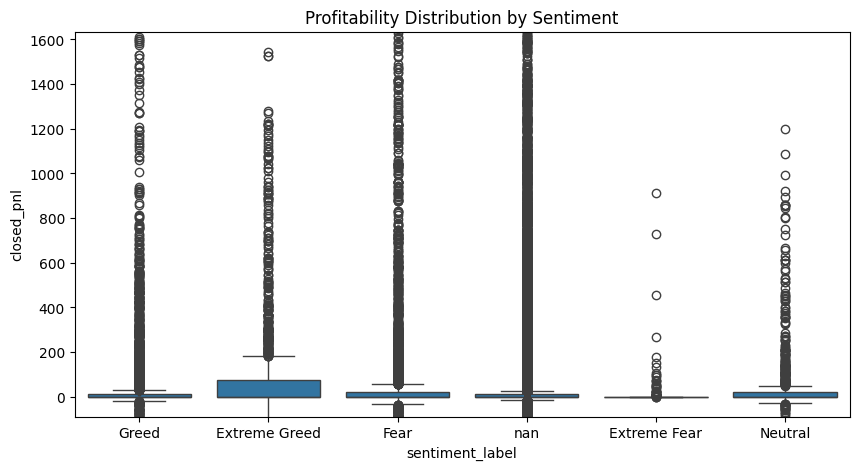

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(x='sentiment_label', y='closed_pnl', data=merged)
plt.title("Profitability Distribution by Sentiment")
plt.ylim(merged['closed_pnl'].quantile(0.01), merged['closed_pnl'].quantile(0.99))
plt.show()

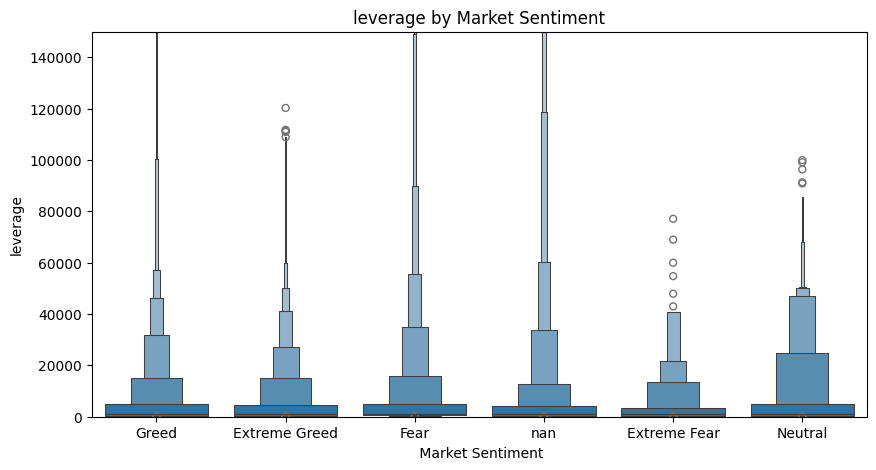

In [ ]:
plt.figure(figsize=(10,5))
sns.boxenplot(x='sentiment_label', y='size_usd', data=merged)
plt.title("leverage by Market Sentiment")
plt.xlabel(" Market Sentiment")
plt.ylabel("leverage")
plt.ylim(0,merged['size_usd'].quantile(0.99))
plt.show()

Average leverage per sentiment

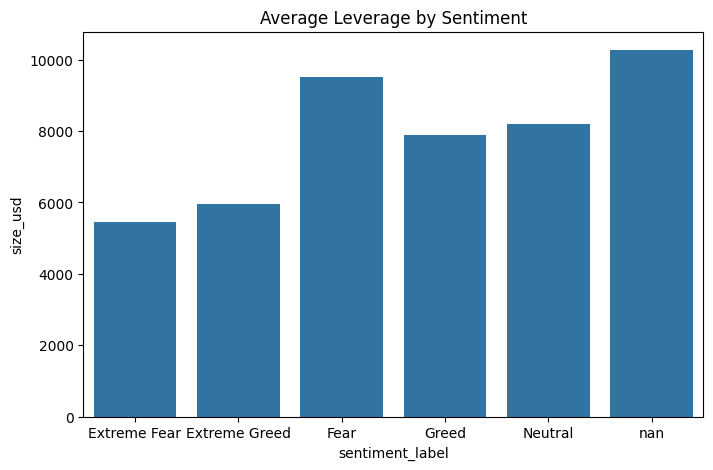

In [ ]:
avg_lev = merged.groupby('sentiment_label')['size_usd'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='sentiment_label', y='size_usd', data=avg_lev)
plt.title("Average Leverage by Sentiment")
plt.show()

test if leverage differs significantly

In [ ]:
from scipy import stats
fear_lev = merged[merged['sentiment_label'] == 'Fear']['size_usd'].dropna()
neutral_lev = merged[merged['sentiment_label'] == 'Neutral']['size_usd'].dropna()
greed_lev = merged[merged['sentiment_label'] == 'Greed']['size_usd'].dropna()
tstat,pval = stats.ttest_ind(fear_lev,neutral_lev)
print("T-test statistic:", tstat)
print("P-value:", pval)

T-test statistic: 1.2282954998608147
P-value: 0.2193758931521385


correlations and quicks stats

,execution_price,closed_pnl
execution_price,1.00000,-0.01582
closed_pnl,-0.01582,1.00000


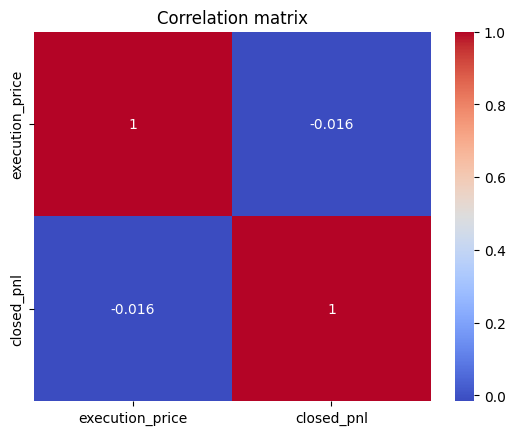

In [ ]:
corr_cols = [c for c in ['execution_price','size','closed_pnl','leverage'] if c in merged.columns]
corr = merged[corr_cols].corr()
display(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()


In [ ]:
merged['profitable'] = (merged['closed_pnl'] > 0).astype(int)

summary = merged.groupby('sentiment_label').agg(
    trades=('profitable','count'),
    mean_pnl=('closed_pnl','mean'),
    median_pnl=('closed_pnl','median'),
    win_rate=('profitable','mean'),
    avg_leverage=('size_usd','mean')
).reset_index()
display(summary)

,sentiment_label,trades,mean_pnl,median_pnl,win_rate,avg_leverage
0,Extreme Fear,204,19.761292,0.0,0.240196,5437.745588
1,Extreme Greed,2107,454.071964,0.0,0.460845,5962.828681
2,Fear,6075,242.440019,0.0,0.400329,9517.741819
3,Greed,5711,79.741839,0.0,0.417440,7891.215067
4,Neutral,1184,37.430126,0.0,0.478885,8181.391005
5,nan,63885,68.274964,0.0,0.455302,10269.487691


Predict whether a trade is profitable

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


features = []
for c in ['size','leverage']:
    if c in merged.columns:
        features.append(c)

if 'classification' in merged.columns and merged['classification'].dtype.kind in 'iuf':
    merged['sentiment_numeric'] = merged['classification']
    features.append('sentiment_numeric')
else:

    merged['sentiment_flag'] = pd.factorize(merged['sentiment_label'])[0]
    features.append('sentiment_flag')


model_df = merged.dropna(subset=features+['profitable'])
X = model_df[features]
y = model_df['profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, prob))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8736
           1       0.00      0.00      0.00      7098

    accuracy                           0.55     15834
   macro avg       0.28      0.50      0.36     15834
weighted avg       0.30      0.55      0.39     15834

ROC-AUC: 0.5140014063962712


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
